<a href="https://colab.research.google.com/github/PradyumnG/NN-from-scratch/blob/main/NN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup Kaggle API

In [1]:
!pip install kaggle

!mkdir -p ~/.kaggle

from google.colab import files
files.upload()

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [2]:
import numpy as np
import pandas as pd
import kagglehub
from tqdm import tqdm
from matplotlib import pyplot as plt

Download fashion mnist dataset

In [3]:

path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


Data exploration

In [4]:
train_data = pd.read_csv(path + "/fashion-mnist_train.csv")
test_data = pd.read_csv(path + "/fashion-mnist_test.csv")

In [5]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
labels = np.array(train_data)[:, 0]
images = np.array(train_data)[:, 1:]
unique, counts = np.unique(labels, return_counts=True)

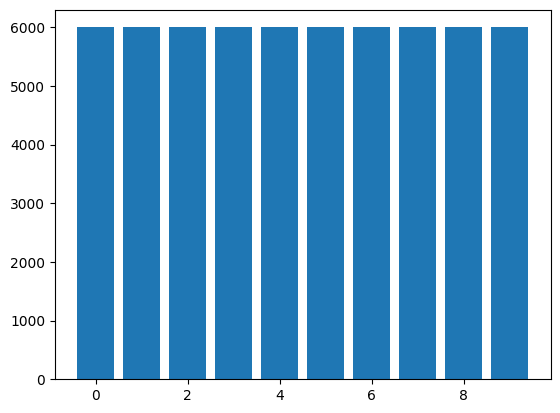

In [7]:
plt.bar(unique, counts)
plt.show()

Utility functions

In [8]:
def compute_accuracy(predictions, true_value):
    assert(predictions.shape ==  true_value.shape)
    return np.sum(predictions==true_value)/predictions.shape[0]

def one_hot_encoding(data):
    assert(data.ndim == 1)

    x = data.shape[0]
    one_hot_encoded = np.zeros(shape=(x, 10))
    one_hot_encoded[np.arange(data.size), data] = 1
    return one_hot_encoded

Loss function class

In [9]:
class LossFn():
    def __cross_entropy(self, predictions, true_value):
        epsilon = 1e-10
        predictions = np.clip(predictions, epsilon, 1-epsilon)

        losses = -np.sum(true_value * np.log(predictions), axis = 1)
        return losses

    # Labels is a column matrix with label for each image
    def cost_fn(self, predictions, labels):
        return self.__cross_entropy(predictions, one_hot_encoding(labels))

Defining the model - 784 - 20 - 10 (output)

In [10]:
EPOCHS = 100
BATCH_SIZE = 32
total_mini_batches = np.array(train_data).shape[0] // BATCH_SIZE

In [11]:
class NN():
    def __init__(self):
        # one row maps to one nodes weights, initialize weights with glorot
        # initialization
        self.layer_1 = np.random.normal(loc = 0.0, scale = np.sqrt(2/(784 + 20)), size = (20, 784))
        self.layer_1_bias = np.random.random(size = (20, 1))
        self.layer_2 = np.random.normal(loc = 0.0, scale = np.sqrt(2/(20 + 10)), size = (10, 20))
        self.layer_2_bias = np.random.random(size = (10, 1))
        self.learning_rate = 1e-3
        self.lossFn = LossFn()

    def __forward_pass(self, data):
        # (x, 784) -> (x, 20)
        data = np.matmul(data, self.layer_1.T) + self.layer_1_bias.T
        # (x, 20) -> (x, 20)
        data = self.tanh(data)
        # (x, 20) -> (x, 10)
        data = np.matmul(data, self.layer_2.T) + self.layer_2_bias.T
        # (x, 10) -> (x, 10)
        data = self.softmax(data)
        # predictions
        return data

    def predict(self, data):
        predictions = self.__forward_pass(data.copy())
        # Index of max predicted value for each data point, each row contains
        # the probability of a particular input
        return np.argmax(predictions, axis = 1)

    def train(self, data, true_value):
        # (x, 784) -> (x, 20)
        z1 = np.matmul(data, self.layer_1.T) + self.layer_1_bias.T
        # (x, 20) -> (x, 20)
        a1 = self.tanh(z1)
        # (x, 20) -> (x, 10)
        z2 = np.matmul(a1, self.layer_2.T) + self.layer_2_bias.T
        # (x, 10) -> (x, 10)
        predictions = self.softmax(z2)

        # Backpropagation starts here

        # dz2.shape = (x, 10)
        dz2 = (predictions - one_hot_encoding(true_value))/data.shape[0]
        # dw2.shape = (10, 20)
        dw2 = np.matmul(dz2.T, a1)
        # db2.shape = (1, 10)
        db2 = np.sum(dz2, axis=0, keepdims=True)
        # dz1.shape = (x, 20)
        dz1 = np.matmul(dz2, self.layer_2) * self.tanh_gradient(z1)
        # dw1.shape = (20, 784)
        dw1 = np.matmul(dz1.T, data)
        # db1.shape = (1, 20)
        db1 = np.sum(dz1, axis=0, keepdims=True)


        # Update weights
        self.layer_1 -= self.learning_rate * dw1
        self.layer_1_bias -= self.learning_rate * db1.T
        self.layer_2 -= self.learning_rate * dw2
        self.layer_2_bias -= self.learning_rate * db2.T

        # Return mini batch total loss
        return self.lossFn.cost_fn(predictions, true_value)

    def tanh(self, data):
        return np.tanh(data)

    def tanh_gradient(self, data):
        return np.ones(data.shape) - np.tanh(data)*np.tanh(data)

    def softmax(self, data):
        data = np.exp(data)
        return data/np.sum(data, axis = 1, keepdims=True)

In [12]:
model = NN()
losses = []
for _ in tqdm(range(EPOCHS)):
    total_loss = 0
    for index in range(total_mini_batches):
        batch_data = np.array(train_data[BATCH_SIZE*index:min(BATCH_SIZE*(index+1), train_data.shape[0])])
        # print(batch_data)
        batch_x = batch_data[:, 1:]
        batch_y = batch_data[:, 0]
        loss = model.train(batch_x, batch_y)
        total_loss += np.sum(loss)
    print(f"Epoch: {_}, Loss: {total_loss}")
    losses.append(total_loss)

  1%|          | 1/100 [00:02<03:44,  2.27s/it]

Epoch: 0, Loss: 108484.32054961797


  2%|▏         | 2/100 [00:03<02:29,  1.53s/it]

Epoch: 1, Loss: 81515.32798616002


  3%|▎         | 3/100 [00:04<01:54,  1.18s/it]

Epoch: 2, Loss: 67724.90994357994


  4%|▍         | 4/100 [00:04<01:37,  1.02s/it]

Epoch: 3, Loss: 58978.53378323437


  5%|▌         | 5/100 [00:05<01:28,  1.07it/s]

Epoch: 4, Loss: 55740.94967349322


  6%|▌         | 6/100 [00:06<01:26,  1.09it/s]

Epoch: 5, Loss: 51925.03542589127


  7%|▋         | 7/100 [00:07<01:20,  1.15it/s]

Epoch: 6, Loss: 49088.48810913302


  8%|▊         | 8/100 [00:08<01:16,  1.20it/s]

Epoch: 7, Loss: 47581.85603510316


  9%|▉         | 9/100 [00:08<01:15,  1.21it/s]

Epoch: 8, Loss: 46509.42291112917


 10%|█         | 10/100 [00:09<01:20,  1.12it/s]

Epoch: 9, Loss: 45559.163083179476


 11%|█         | 11/100 [00:10<01:24,  1.05it/s]

Epoch: 10, Loss: 44850.92489696572


 12%|█▏        | 12/100 [00:11<01:21,  1.08it/s]

Epoch: 11, Loss: 43676.51110060783


 13%|█▎        | 13/100 [00:12<01:20,  1.09it/s]

Epoch: 12, Loss: 44421.96590622238


 14%|█▍        | 14/100 [00:13<01:15,  1.14it/s]

Epoch: 13, Loss: 42782.76114564082


 15%|█▌        | 15/100 [00:14<01:11,  1.18it/s]

Epoch: 14, Loss: 42456.74961173289


 16%|█▌        | 16/100 [00:15<01:10,  1.18it/s]

Epoch: 15, Loss: 41541.295991334366


 17%|█▋        | 17/100 [00:15<01:09,  1.19it/s]

Epoch: 16, Loss: 41514.34282661441


 18%|█▊        | 18/100 [00:16<01:07,  1.22it/s]

Epoch: 17, Loss: 40819.63350932079


 19%|█▉        | 19/100 [00:17<01:05,  1.24it/s]

Epoch: 18, Loss: 40491.69073615432


 20%|██        | 20/100 [00:18<01:04,  1.23it/s]

Epoch: 19, Loss: 41036.43032996088


 21%|██        | 21/100 [00:19<01:04,  1.23it/s]

Epoch: 20, Loss: 40923.66612640134


 22%|██▏       | 22/100 [00:19<01:03,  1.22it/s]

Epoch: 21, Loss: 39841.31191306413


 23%|██▎       | 23/100 [00:20<01:06,  1.16it/s]

Epoch: 22, Loss: 40411.98785489789


 24%|██▍       | 24/100 [00:22<01:12,  1.06it/s]

Epoch: 23, Loss: 38661.49174928856


 25%|██▌       | 25/100 [00:22<01:08,  1.10it/s]

Epoch: 24, Loss: 39206.00445411981


 26%|██▌       | 26/100 [00:23<01:04,  1.15it/s]

Epoch: 25, Loss: 38613.348863553896


 27%|██▋       | 27/100 [00:24<01:03,  1.16it/s]

Epoch: 26, Loss: 38846.8794738094


 28%|██▊       | 28/100 [00:25<01:02,  1.15it/s]

Epoch: 27, Loss: 38383.08638337082


 29%|██▉       | 29/100 [00:26<01:00,  1.17it/s]

Epoch: 28, Loss: 38458.41856189103


 30%|███       | 30/100 [00:27<00:59,  1.18it/s]

Epoch: 29, Loss: 37940.49712653037


 31%|███       | 31/100 [00:27<00:59,  1.16it/s]

Epoch: 30, Loss: 37278.99260749168


 32%|███▏      | 32/100 [00:28<00:59,  1.15it/s]

Epoch: 31, Loss: 37405.4744020621


 33%|███▎      | 33/100 [00:29<00:58,  1.15it/s]

Epoch: 32, Loss: 36874.7970537353


 34%|███▍      | 34/100 [00:30<00:58,  1.12it/s]

Epoch: 33, Loss: 37382.412099573885


 35%|███▌      | 35/100 [00:31<00:56,  1.16it/s]

Epoch: 34, Loss: 36481.85104773395


 36%|███▌      | 36/100 [00:32<00:55,  1.16it/s]

Epoch: 35, Loss: 37219.13444967984


 37%|███▋      | 37/100 [00:33<00:58,  1.07it/s]

Epoch: 36, Loss: 36464.609824253326


 38%|███▊      | 38/100 [00:34<00:55,  1.11it/s]

Epoch: 37, Loss: 37206.82274936283


 39%|███▉      | 39/100 [00:35<00:53,  1.13it/s]

Epoch: 38, Loss: 36344.98121019461


 40%|████      | 40/100 [00:35<00:52,  1.14it/s]

Epoch: 39, Loss: 36394.75817659006


 41%|████      | 41/100 [00:36<00:51,  1.14it/s]

Epoch: 40, Loss: 36324.769175740345


 42%|████▏     | 42/100 [00:37<00:49,  1.18it/s]

Epoch: 41, Loss: 37589.479096494404


 43%|████▎     | 43/100 [00:38<00:47,  1.20it/s]

Epoch: 42, Loss: 36053.32563938095


 44%|████▍     | 44/100 [00:39<00:45,  1.23it/s]

Epoch: 43, Loss: 35853.20720779742


 45%|████▌     | 45/100 [00:39<00:43,  1.25it/s]

Epoch: 44, Loss: 34853.225803331145


 46%|████▌     | 46/100 [00:40<00:42,  1.26it/s]

Epoch: 45, Loss: 35321.51553754219


 47%|████▋     | 47/100 [00:41<00:41,  1.28it/s]

Epoch: 46, Loss: 36802.131315006074


 48%|████▊     | 48/100 [00:42<00:40,  1.29it/s]

Epoch: 47, Loss: 35370.23114029854


 49%|████▉     | 49/100 [00:43<00:40,  1.26it/s]

Epoch: 48, Loss: 34969.40830385843


 50%|█████     | 50/100 [00:44<00:43,  1.14it/s]

Epoch: 49, Loss: 35023.68218487358


 51%|█████     | 51/100 [00:45<00:45,  1.07it/s]

Epoch: 50, Loss: 34779.87554456955


 52%|█████▏    | 52/100 [00:46<00:42,  1.12it/s]

Epoch: 51, Loss: 34677.79129398441


 53%|█████▎    | 53/100 [00:46<00:40,  1.16it/s]

Epoch: 52, Loss: 33838.28755320806


 54%|█████▍    | 54/100 [00:47<00:38,  1.20it/s]

Epoch: 53, Loss: 34613.59723907398


 55%|█████▌    | 55/100 [00:48<00:36,  1.22it/s]

Epoch: 54, Loss: 35114.04953716459


 56%|█████▌    | 56/100 [00:49<00:35,  1.23it/s]

Epoch: 55, Loss: 33742.57548840625


 57%|█████▋    | 57/100 [00:49<00:34,  1.25it/s]

Epoch: 56, Loss: 34760.93533085772


 58%|█████▊    | 58/100 [00:50<00:33,  1.25it/s]

Epoch: 57, Loss: 34797.47287184492


 59%|█████▉    | 59/100 [00:51<00:32,  1.27it/s]

Epoch: 58, Loss: 34095.720728122586


 60%|██████    | 60/100 [00:52<00:31,  1.28it/s]

Epoch: 59, Loss: 34958.466652263756


 61%|██████    | 61/100 [00:53<00:30,  1.28it/s]

Epoch: 60, Loss: 34615.95474216207


 62%|██████▏   | 62/100 [00:53<00:29,  1.28it/s]

Epoch: 61, Loss: 35000.55387560207


 63%|██████▎   | 63/100 [00:54<00:28,  1.29it/s]

Epoch: 62, Loss: 33819.00144950894


 64%|██████▍   | 64/100 [00:55<00:31,  1.15it/s]

Epoch: 63, Loss: 33197.365670104395


 65%|██████▌   | 65/100 [00:56<00:32,  1.09it/s]

Epoch: 64, Loss: 33533.36647570193


 66%|██████▌   | 66/100 [00:57<00:30,  1.10it/s]

Epoch: 65, Loss: 33832.8082956376


 67%|██████▋   | 67/100 [00:58<00:28,  1.15it/s]

Epoch: 66, Loss: 33472.5689370029


 68%|██████▊   | 68/100 [00:59<00:27,  1.17it/s]

Epoch: 67, Loss: 33866.622371665886


 69%|██████▉   | 69/100 [00:59<00:25,  1.21it/s]

Epoch: 68, Loss: 33308.82648004533


 70%|███████   | 70/100 [01:00<00:24,  1.23it/s]

Epoch: 69, Loss: 33222.61743712777


 71%|███████   | 71/100 [01:01<00:24,  1.20it/s]

Epoch: 70, Loss: 33686.71302669699


 72%|███████▏  | 72/100 [01:02<00:22,  1.22it/s]

Epoch: 71, Loss: 34448.58162660596


 73%|███████▎  | 73/100 [01:03<00:22,  1.20it/s]

Epoch: 72, Loss: 34209.246787925535


 74%|███████▍  | 74/100 [01:04<00:21,  1.20it/s]

Epoch: 73, Loss: 33718.05346429267


 75%|███████▌  | 75/100 [01:04<00:20,  1.22it/s]

Epoch: 74, Loss: 34198.851063735274


 76%|███████▌  | 76/100 [01:05<00:19,  1.24it/s]

Epoch: 75, Loss: 33042.76933883


 77%|███████▋  | 77/100 [01:06<00:19,  1.20it/s]

Epoch: 76, Loss: 33078.568285231595


 78%|███████▊  | 78/100 [01:07<00:20,  1.07it/s]

Epoch: 77, Loss: 33287.98156368227


 79%|███████▉  | 79/100 [01:08<00:19,  1.09it/s]

Epoch: 78, Loss: 32924.10056434943


 80%|████████  | 80/100 [01:09<00:18,  1.11it/s]

Epoch: 79, Loss: 33686.731270760465


 81%|████████  | 81/100 [01:10<00:16,  1.13it/s]

Epoch: 80, Loss: 32812.1728634467


 82%|████████▏ | 82/100 [01:11<00:15,  1.18it/s]

Epoch: 81, Loss: 35173.06869727987


 83%|████████▎ | 83/100 [01:11<00:14,  1.18it/s]

Epoch: 82, Loss: 32292.076623773653


 84%|████████▍ | 84/100 [01:12<00:13,  1.21it/s]

Epoch: 83, Loss: 32779.282111252665


 85%|████████▌ | 85/100 [01:13<00:12,  1.20it/s]

Epoch: 84, Loss: 32786.760341612855


 86%|████████▌ | 86/100 [01:14<00:11,  1.18it/s]

Epoch: 85, Loss: 31943.63212998545


 87%|████████▋ | 87/100 [01:15<00:11,  1.16it/s]

Epoch: 86, Loss: 33083.12966542795


 88%|████████▊ | 88/100 [01:16<00:10,  1.17it/s]

Epoch: 87, Loss: 32818.584329626894


 89%|████████▉ | 89/100 [01:16<00:09,  1.21it/s]

Epoch: 88, Loss: 32752.06063813118


 90%|█████████ | 90/100 [01:17<00:08,  1.21it/s]

Epoch: 89, Loss: 32297.92521997188


 91%|█████████ | 91/100 [01:18<00:08,  1.11it/s]

Epoch: 90, Loss: 32423.020867280626


 92%|█████████▏| 92/100 [01:19<00:07,  1.07it/s]

Epoch: 91, Loss: 32745.29382158538


 93%|█████████▎| 93/100 [01:20<00:06,  1.12it/s]

Epoch: 92, Loss: 32384.958472861585


 94%|█████████▍| 94/100 [01:21<00:05,  1.17it/s]

Epoch: 93, Loss: 33116.658334872096


 95%|█████████▌| 95/100 [01:22<00:04,  1.21it/s]

Epoch: 94, Loss: 33153.479395445465


 96%|█████████▌| 96/100 [01:22<00:03,  1.20it/s]

Epoch: 95, Loss: 32820.388985562946


 97%|█████████▋| 97/100 [01:23<00:02,  1.21it/s]

Epoch: 96, Loss: 32917.62440171548


 98%|█████████▊| 98/100 [01:24<00:01,  1.23it/s]

Epoch: 97, Loss: 32219.43076557949


 99%|█████████▉| 99/100 [01:25<00:00,  1.22it/s]

Epoch: 98, Loss: 31563.052664295643


100%|██████████| 100/100 [01:26<00:00,  1.16it/s]

Epoch: 99, Loss: 33096.080874093925


Visualizing loss

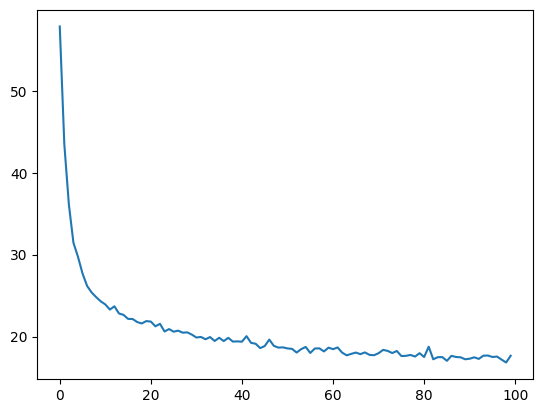

In [13]:
plt.plot(np.arange(EPOCHS), np.array(losses)/total_mini_batches)
plt.show()

Testing the model using test data

In [14]:
predictions = model.predict(np.array(test_data)[:, 1:])
test_labels = np.array(test_data)[:,0]
print(f"Accuracy: {compute_accuracy(predictions, test_labels)}")

Accuracy: 0.8174
